In [27]:
import json
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib.colors import Normalize
import matplotlib.colors as colors
import os

In [28]:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{tgheros}',
                                       r'\usepackage{sansmath}',
                                       r'\sansmath',
                                       r'\usepackage{siunitx}',
                                       r'\sisetup{detect-all}']
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 18

In [29]:
def savefig(fig, filename):
    cmd = 'convert {} -trim {}'.format(filename, filename)
    fig.savefig(filename, bbox_inches='tight', dpi=300)
    os.system(cmd)

In [30]:
class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        #I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [31]:
from scipy.stats import iqr

def kde_nd(x, y, weight=None, stats=False):
    '''Kernel density estimator
    
    ...
    
    Arguments
    ---------
    x : list of ndarrays
        Measured data points
        
    y : list of ndarrays
        Points at which the density should be estimated
        
    Keywords
    --------
    weight: ndarray
        Value at each of the measured data points.
        Default: 1.
        
    stats: bool
        Return statistical information, if True
        
    Returns
    -------
    rho: ndarray
        Density at each of the sampling points, optionally weighted
        by the specified values
    scale: ndarray | optional
        Scale factors for each of the dimensions in the list of
        measured data points.
    sigma: ndarray | optional
        Variance of the returned value at each sampling point.
    '''
    nd = len(x)     # number of dimensions
    nx = x[0].size  # number of data points
    ny = y[0].size  # number of sample points
    
    # optimal smoothing parameter in each dimension
    # Silverman Eqs. (3.30) and (3.31)
    sx = [this.std() for this in x]
    rx = [iqr(this) for this in x]
    h = np.array(sx)
    for n in range(nd):
        if (rx[n] > 1e-10):
            h[n] = np.min([sx[n], rx[n]/1.34])
        h[n] *= 0.9/nx**0.2
    
    # density estimate
    # Silverman Eq. (2.15) and Table 3.1
    t = np.array([this/h[n] for n, this in enumerate(x)]).T
    s = np.array([this/h[n] for n, this in enumerate(y)]).T

    if weight is None:
        weight = np.ones(nx)
    normalization = weight * np.prod((2.*np.pi*h**2)**(-0.5))/nx
    
    rho = np.empty(ny)
    sigma = np.empty(ny)
    for n in range(ny):
        z = 0.5 * np.sum((t - s[n,:])**2, axis=1)
        value = normalization * np.exp(-z)
        rho[n] = np.sum(value)
        sigma[n] = np.sum(value**2)
    if stats:
        return rho, h, sigma
    return rho

In [32]:
def akde_nd(x, y, weight=None, alpha=0.5):
    nd = len(x)     # number of dimensions
    nx = x[0].size  # number of data points
    ny = y[0].size  # number of sample points
    
    # Method described by Silverman Sec. 5.3.1
    # 1. pilot estimate of the density at the data points
    rho, scale, sigma = kde_nd(x, x, stats=True)
    
    # 2. local bandwidth factor
    g = np.exp(np.mean(np.log(rho))) # geometric mean density
    factor = (g/rho)**alpha          # Eq. (5.7)
    h = np.outer(factor, scale)      # Scale for each input point
    
    # 3. adaptive density estimate
    if weight is None:
        weight = np.ones(nx)
    normalization = weight * (2.*np.pi * np.sum(h**2, axis=1))**(-nd/2.) / nx

    t = np.array(x).T
    s = np.array(y).T
    rho = np.empty(ny)
    for n in range(ny):
        z = 0.5 * np.sum(((t - s[n,:])/h)**2, axis=1)
        value = normalization * np.exp(-z)
        rho[n] = np.sum(value)
    return rho

In [33]:
def distribution(data, value, nx=100, ny=100):
    x = np.linspace(min(data[0]), max(data[0]), nx)
    y = np.linspace(min(data[1]), max(data[1]), ny)
    xx, yy = np.meshgrid(x, y)
    sample = [xx.ravel(), yy.ravel()]
    rhow = akde_nd(data, sample, value)
    rho = akde_nd(data, sample)
    return (rhow/rho).reshape(nx, ny), xx, yy

In [34]:
with open('data/DDA_sphere_validation_largerange.json', 'r') as f:
    data = json.load(f)
    
df = pd.DataFrame(data)

d_p = df.a_p.to_numpy()*2
n_p = df.n_p.to_numpy()
a_fit = df['a_p*']
n_fit = df['n_p*']

da_p = (a_fit - df.a_p).to_numpy()*2e3
dn_p = (n_fit - df.n_p).to_numpy()*1e3

In [35]:
dda_p, xx, yy = distribution([d_p, n_p], da_p)
ddn_p, xx, yy = distribution([d_p, n_p], dn_p)

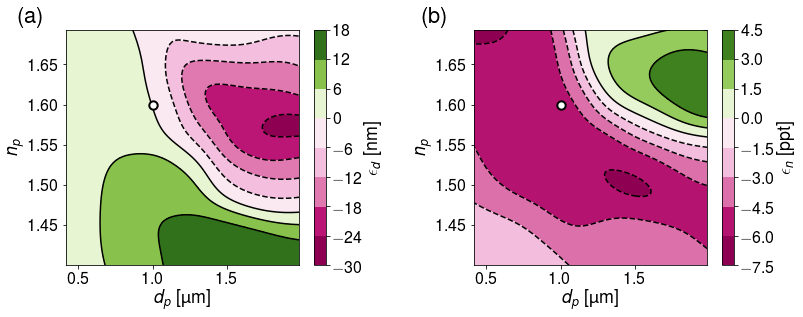

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(11,4))

dd = [dda_p, ddn_p]
labels = [r'$\epsilon_d$ [\si{nm}]',
          r'$\epsilon_n$ [ppt]']
letters = [r'(a)', r'(b)']
for n, ax in enumerate(axes):
    ct = ax.contourf(xx, yy, dd[n], cmap='PiYG', norm=MidpointNormalize(midpoint=0,vmin=np.min(dd[n]), vmax=np.max(dd[n])))
    ax.contour(xx, yy, dd[n], colors='k')
    cb = fig.colorbar(ct, ax=ax)
    cb.set_label(labels[n])
    ax.set_xlabel(r'$d_p$ [\si{\um}]')
    ax.scatter([1.0], [1.60], color='white', edgecolor='black', s=70, linewidth=2, zorder=10)
    fig.text(0.51*n+0.015,1, letters[n], fontsize=22)
    ax.set_ylabel(r'$n_p$')

    
fig.tight_layout(pad=0.1)
fig.subplots_adjust(wspace=0.4)

savefig(fig, 'figures/sphere_validation03.png')